In [1]:
# %pip install featuretools

In [11]:
import sys, os
from pathlib import Path

# 1) Obtener la ruta al directorio del proyecto (un nivel arriba de notebooks/)
project_root = Path().resolve().parent

# 2a) Opción A: que Python vea "src" como paquete:
sys.path.insert(0, str(project_root))

# 2b) Opción B (más directo), apuntar directamente a src/, y usar import desde eda:
# sys.path.insert(0, str(project_root / "src"))

print("PYTHONPATH:", sys.path[:3])

PYTHONPATH: ['C:\\Users\\leona\\source\\repos\\fau_predic_salario', 'c:\\Users\\leona\\source\\repos\\fau_predic_salario', 'C:\\Users\\leona\\source\\repos\\fau_predic_salario']


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
import featuretools as ft
from featuretools.selection import (
    remove_low_information_features,
    remove_highly_correlated_features
)
import pandas as pd
from src.eda.eda import merge_multiple_dataframes
#Configuración de parametros de Pandas para mejor visualización
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 3)
pd.set_option('plotting.backend', 'matplotlib') 
pd.options.mode.chained_assignment = None

# En produccion eliminar, se incluye por informacion
print(f'Pandas Version: {pd.__version__}') 

# En produccion eliminar, se incluye por informacion
print(f'Featuretools Version: {ft.__version__}') 

Pandas Version: 2.1.4
Featuretools Version: 1.31.0


In [ ]:
# Cargar los datos
file_paths = ['../data/descriptions.csv', '../data/people.csv', '../data/salary.csv']

df_people      = pd.read_csv("../data/people.csv")
df_descriptions = pd.read_csv("../data/descriptions.csv")
df_salary      = pd.read_csv("../data/salary.csv")

# Cargar los datos
file_paths = ['../data/descriptions.csv', '../data/people.csv', '../data/salary.csv']
df_merged = merge_multiple_dataframes(file_paths, 'id')

In [15]:
print(df_merged.isnull().sum())

id                     0
Age                    5
Gender                 5
Education Level        5
Job Title              5
Years of Experience    2
Salary                 2
Description            3
dtype: int64


In [ ]:
# Unir los tres dataframes por 'id'
#df_merged = df_people.merge(df_salary, on="id").merge(df_descriptions, on="id")

# Eliminar filas con valores nulos
df_merged_clean = df_merged.dropna().reset_index(drop=True)

# Crear IDs categóricos para job title y education level
df_merged_clean['job_title_id'] = df_merged_clean['Job Title'].astype('category').cat.codes
df_merged_clean['education_id'] = df_merged_clean['Education Level'].astype('category').cat.codes

# Crear tablas auxiliares
df_job_titles = df_merged_clean[['job_title_id', 'Job Title']].drop_duplicates().reset_index(drop=True)
df_education = df_merged_clean[['education_id', 'Education Level']].drop_duplicates().reset_index(drop=True)

# Crear EntitySet
es = ft.EntitySet(id="employee_data")

# Agregar dataframes
es = es.add_dataframe(dataframe_name="people", dataframe=df_merged_clean, index="id")
es = es.add_dataframe(dataframe_name="job_titles", dataframe=df_job_titles, index="job_title_id")
es = es.add_dataframe(dataframe_name="education_levels", dataframe=df_education, index="education_id")

# Definir relaciones
rel_job = ft.Relationship(es, "job_titles", "job_title_id", "people", "job_title_id")
rel_edu = ft.Relationship(es, "education_levels", "education_id", "people", "education_id")
es = es.add_relationships([rel_job, rel_edu])

# Aplicar Deep Feature Synthesis
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="people",
    agg_primitives=["mean"],  # Solo promedio
    trans_primitives=[],      # Ninguna transformación adicional
    verbose=True
)

# Guardar o visualizar resultados
feature_matrix.to_csv("feature_matrix.csv", index=False)
print(feature_matrix.head())

c:\Users\leona\anaconda3\envs\funda_apre_auto\lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
c:\Users\leona\anaconda3\envs\funda_apre_auto\lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
c:\Users\leona\anaconda3\envs\funda_apre_auto\lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
c:\Users\leona\anaconda3\envs\funda_apre_auto\lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: C

Built 13 features
Elapsed: 00:00 | Progress: 100%|██████████
     Age  Gender Education Level  Years of Experience    Salary  job_title_id  \
id                                                                              
0   32.0    Male      Bachelor's                  5.0   90000.0           156   
1   28.0  Female        Master's                  3.0   65000.0            16   
2   45.0    Male             PhD                 15.0  150000.0           128   
3   36.0  Female      Bachelor's                  7.0   60000.0            99   
4   52.0    Male        Master's                 20.0  200000.0            21   

    education_id  job_titles.MEAN(people.Age)  job_titles.MEAN(people.Salary)  \
id                                                                              
0              0                         32.0                         90000.0   
1              1                         34.5                         72500.0   
2              2                         45.5  

c:\Users\leona\anaconda3\envs\funda_apre_auto\lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:785: FutureWarning: The provided callable <function mean at 0x0000024F9B8F4040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  ).agg(to_agg)
c:\Users\leona\anaconda3\envs\funda_apre_auto\lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:785: FutureWarning: The provided callable <function mean at 0x0000024F9B8F4040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  ).agg(to_agg)


In [7]:
feature_matrix.head()

,Age,Gender,Education Level,Years of Experience,Salary,job_title_id,education_id,job_titles.MEAN(people.Age),job_titles.MEAN(people.Salary),job_titles.MEAN(people.Years of Experience),education_levels.MEAN(people.Age),education_levels.MEAN(people.Salary),education_levels.MEAN(people.Years of Experience)
id,,,,,,,,,,,,,
0,32.0,Male,Bachelor's,5.0,90000.0,156,0,32.0,90000.0,5.0,34.282,74555.634,6.960
1,28.0,Female,Master's,3.0,65000.0,16,1,34.5,72500.0,8.0,40.716,129947.368,13.358
2,45.0,Male,PhD,15.0,150000.0,128,2,45.5,160000.0,17.5,44.720,157800.000,17.040
3,36.0,Female,Bachelor's,7.0,60000.0,99,0,32.5,50000.0,5.0,34.282,74555.634,6.960
4,52.0,Male,Master's,20.0,200000.0,21,1,52.0,200000.0,20.0,40.716,129947.368,13.358


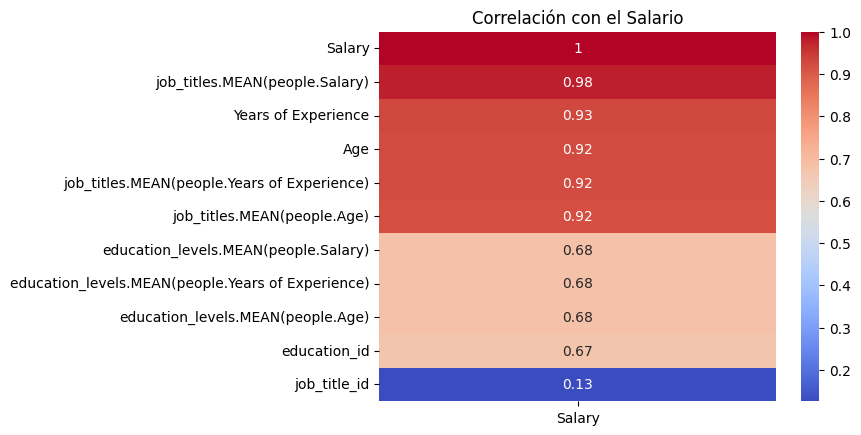

In [8]:
import numpy as np

# Filtrar solo columnas numéricas
numeric_df = feature_matrix.select_dtypes(include=[np.number])

# Matriz de correlación
corr = numeric_df.corr()

# Heatmap
sns.heatmap(corr[['Salary']].sort_values(by='Salary', ascending=False), annot=True, cmap='coolwarm')
plt.title("Correlación con el Salario")
plt.show()

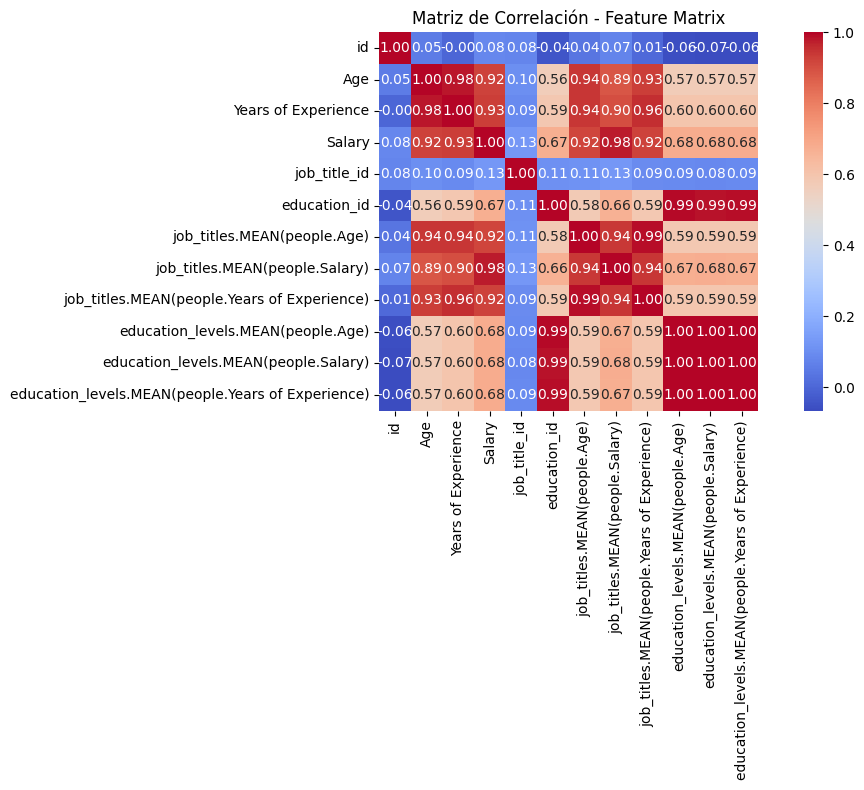

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Si ya tenés el archivo con el feature_matrix exportado:
# feature_matrix = pd.read_csv("feature_matrix.csv")

# Suponiendo que ya hiciste merge con Job Title y Education Level
df_visual = feature_matrix.merge(
    df_merged_clean[['id', 'Job Title', 'Education Level']],
    on='id',
    how='left'
)

# Filtrar solo columnas numéricas
numeric_df = df_visual.select_dtypes(include=[np.number])

# Matriz de correlación
corr = numeric_df.corr()

# Gráfico de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de Correlación - Feature Matrix")
plt.tight_layout()
plt.show()


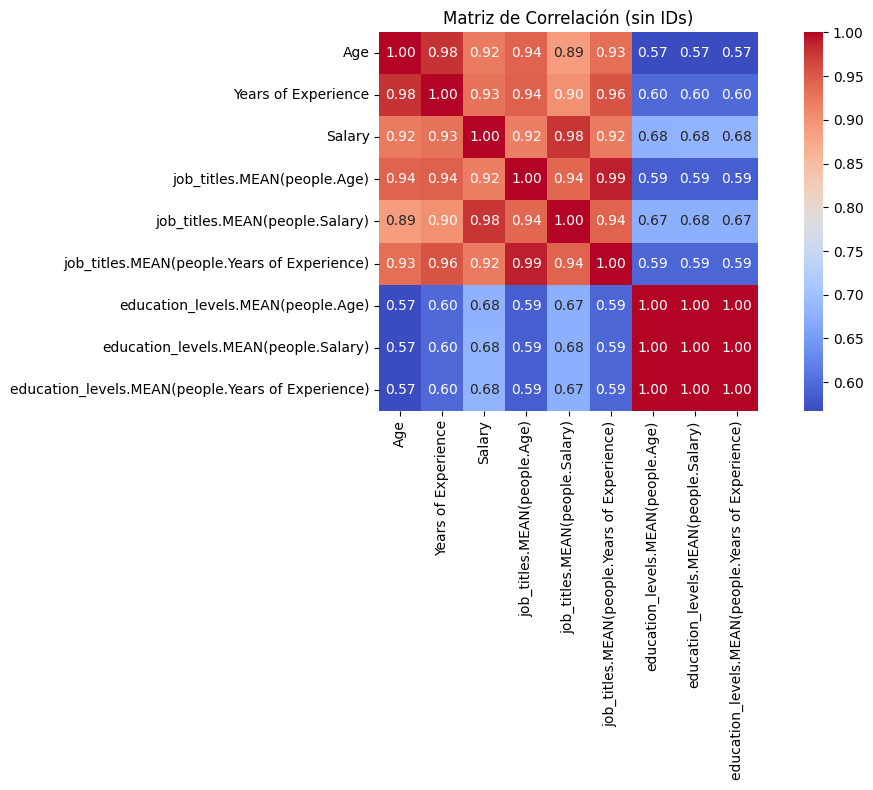

In [10]:
# 1. Crear una copia del DataFrame numérico
numeric_df = df_visual.select_dtypes(include=[np.number]).copy()

# 2. Eliminar columnas que son identificadores
cols_to_drop = ['id', 'job_title_id', 'education_id']
numeric_df = numeric_df.drop(columns=[col for col in cols_to_drop if col in numeric_df.columns])

# 3. Calcular y graficar la matriz de correlación
corr = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de Correlación (sin IDs)")
plt.tight_layout()
plt.show()
